In [1]:
dataset_path = '/code/root/tfrecords'

In [2]:
import os
import shutil
import json
import jax
import optax
import hashlib
import jax.numpy as jnp
import jax.random as random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from flax import struct
from flax.training import train_state
from tqdm.notebook import tqdm  # Better for Jupyter
import time
from functools import partial
from collections import defaultdict

from typing import NamedTuple, Any

In [3]:
def visualize_reconstructions(state, cached_images, cached_waves, key, num_samples=6):

    # Select random samples from cached batch
    key, subkey = random.split(key)
    batch_size = cached_images.shape[0]
    num_samples = min(num_samples, batch_size)
    indices = random.choice(subkey, batch_size, (num_samples,), replace=False)
    original_images = cached_images[indices]
    
    # Get reconstructions
    key, subkey = random.split(key)
    reconstructed_images, _, _, _ = reconstruct_batch(state, cached_waves[indices], subkey)
    
    # Convert to numpy for plotting
    original_np = np.array(original_images)
    reconstructed_np = np.array(reconstructed_images)

    fig, axs = plt.subplots(num_samples, 2)
    for k in range(num_samples):
        axs[k, 0].imshow(original_np[k, ...])
        axs[k, 1].imshow(reconstructed_np[k, ...])
    plt.show()
    plt.close()
    
    return key

🔧 Checking GPU availability...
JAX devices: [CudaDevice(id=0)]
JAX default backend: gpu
✅ Found 1 GPU(s): [CudaDevice(id=0)]
🎯 Setting JAX to use GPU...
Initializing VAE model...
Model initialized!
📋 Training Configuration:
   Learning Rate: 0.01
   Epochs: 200
   Batch Size: 32

📂 Setting up dataloader...
Found 32 TFRecord files
Dataloader ready!

Starting training loop...
--------------------------------------------------------------------------------


Adaptive Training Progress:   0%|          | 0/200 [00:00<?, ?it/s]

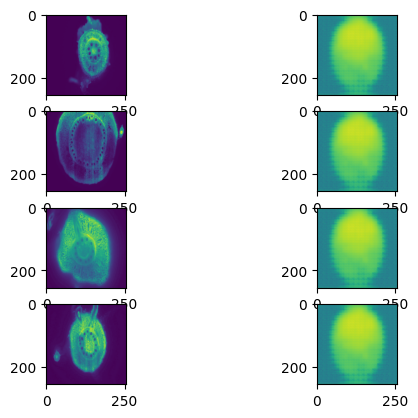

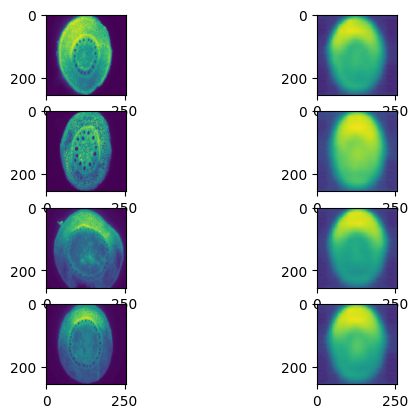

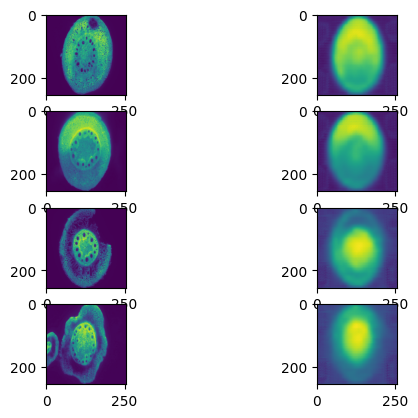

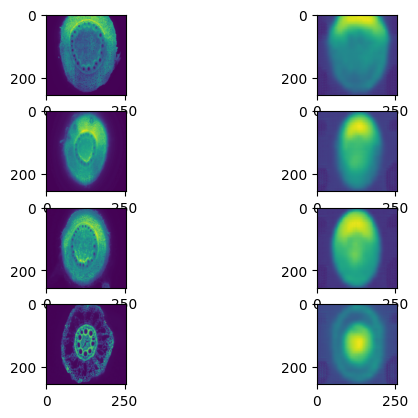

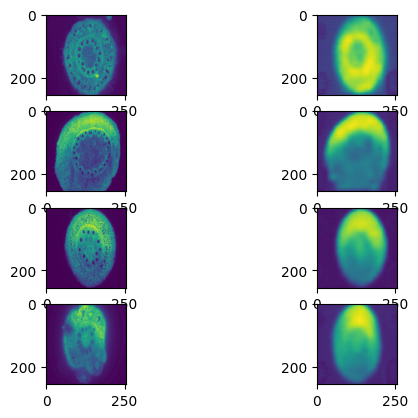

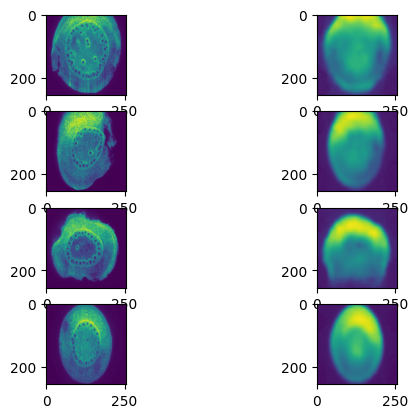

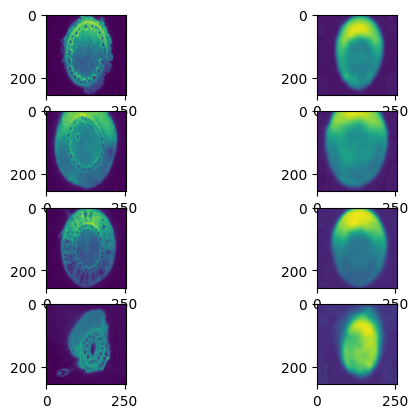

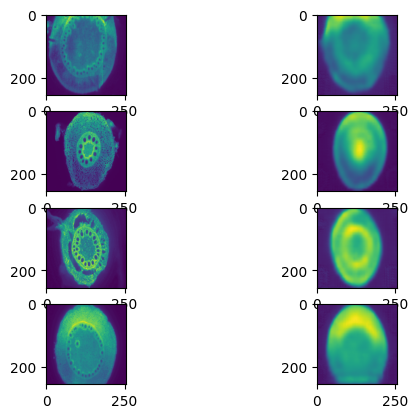

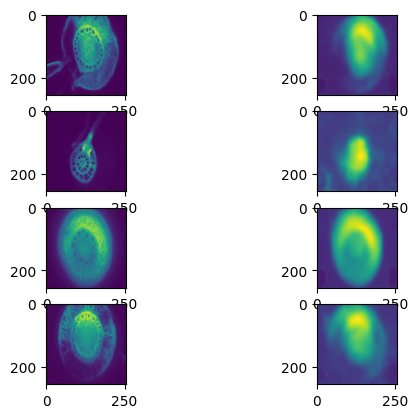

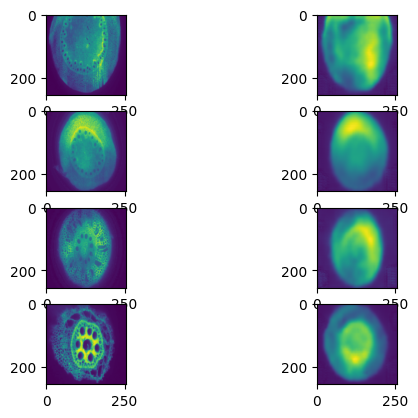

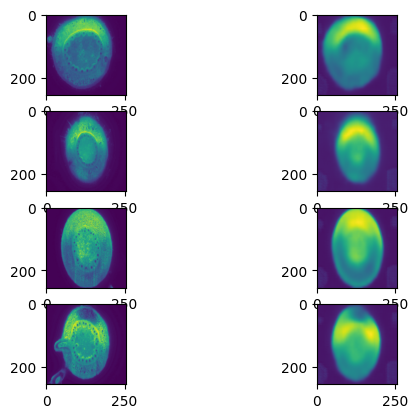

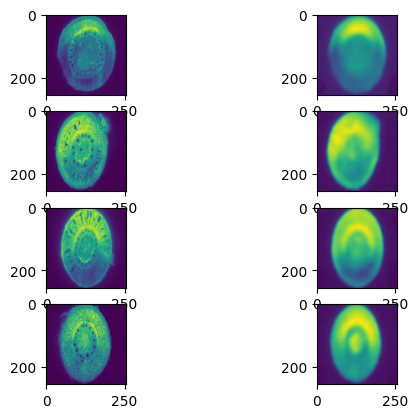

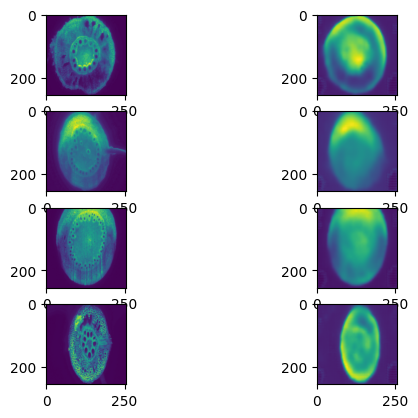

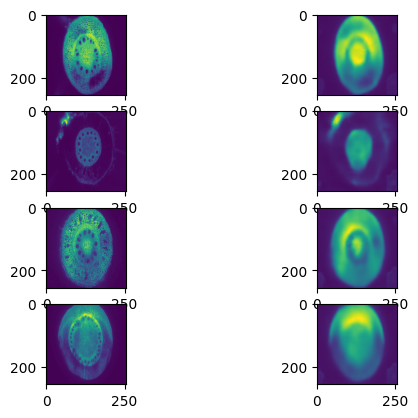

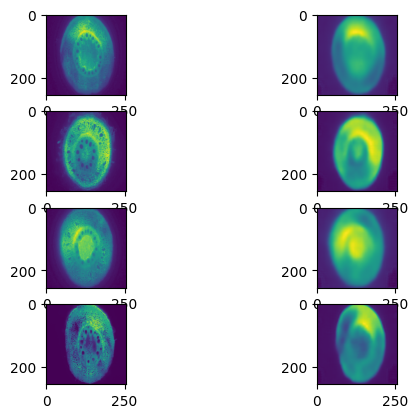

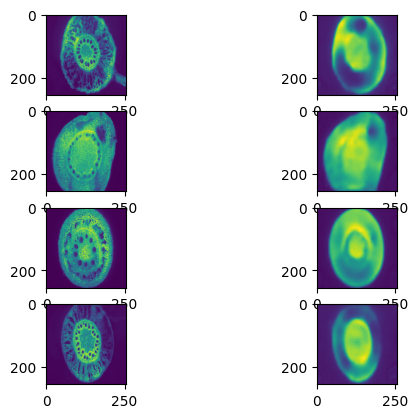

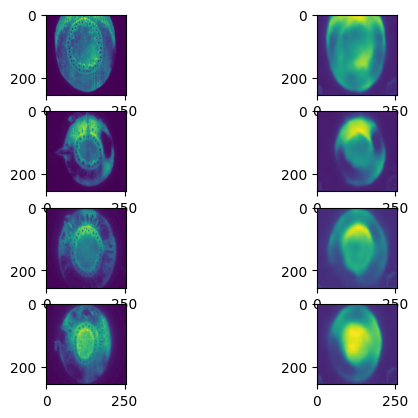

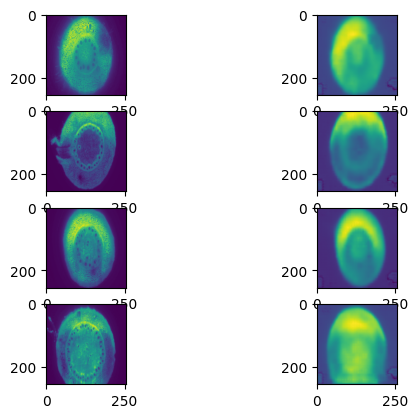

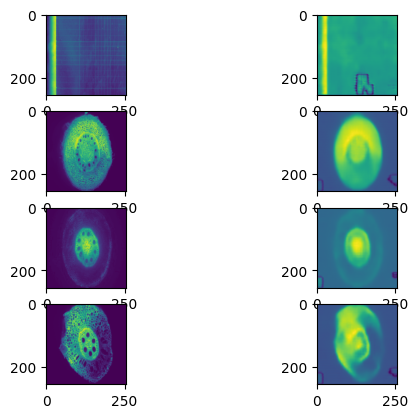

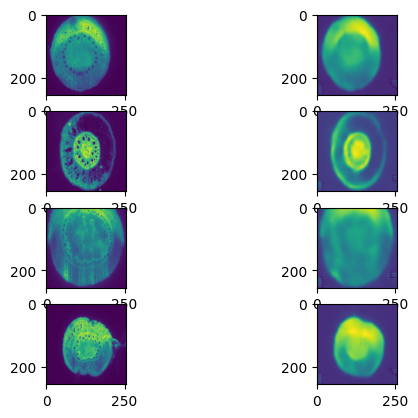

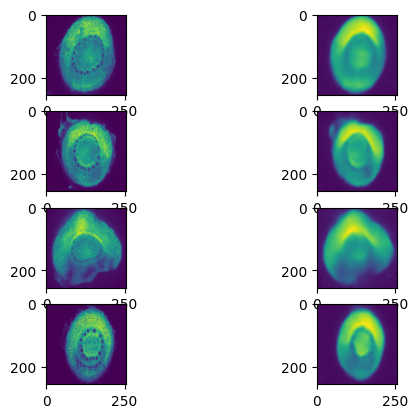

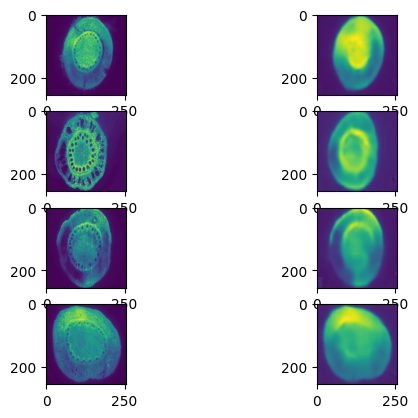

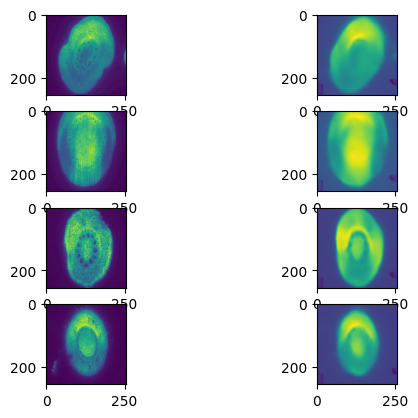

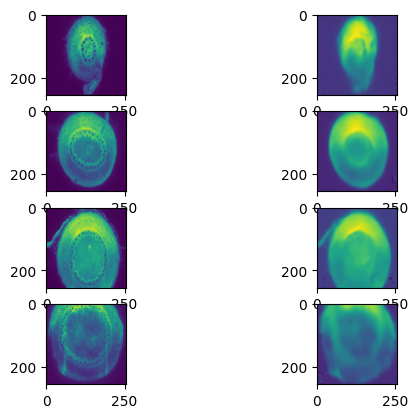

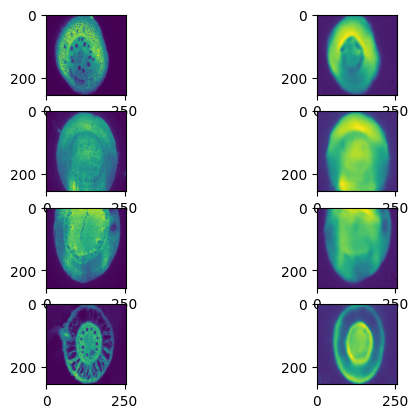

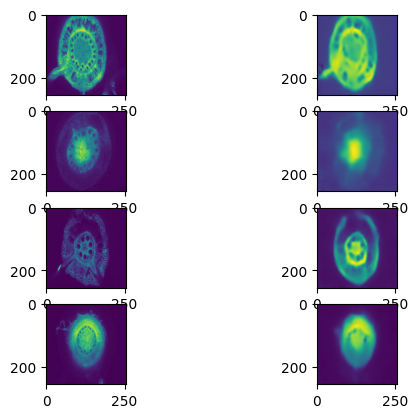

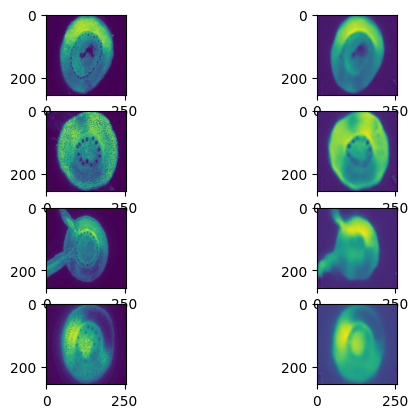

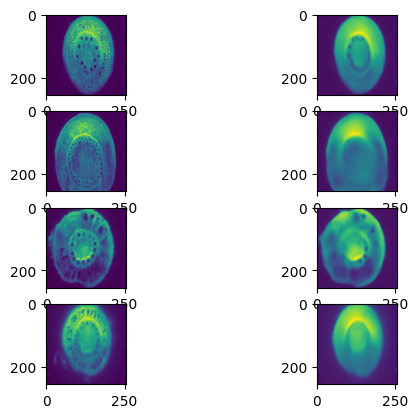

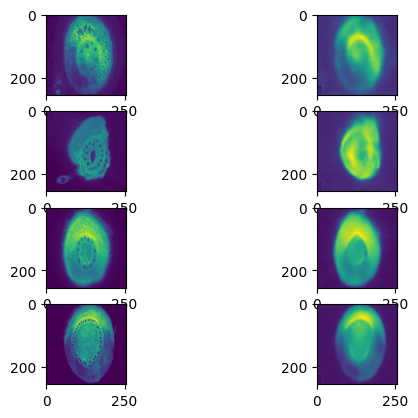

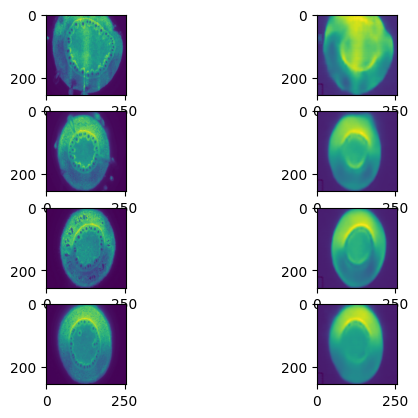

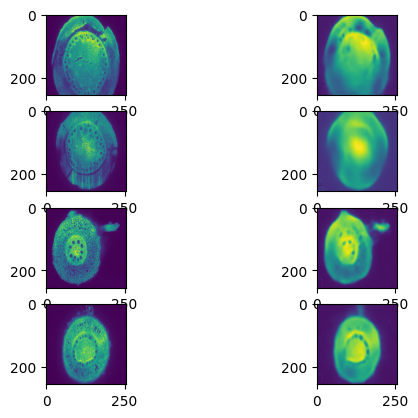

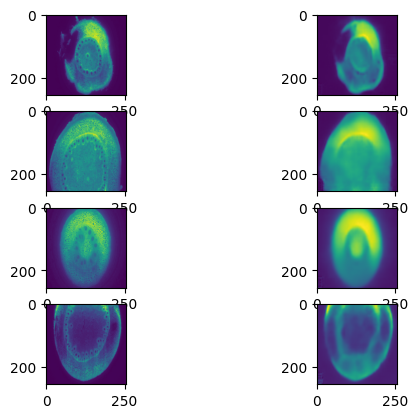

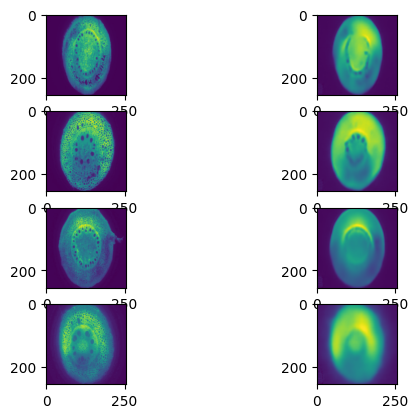

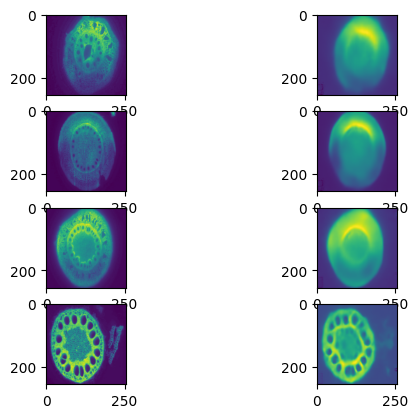

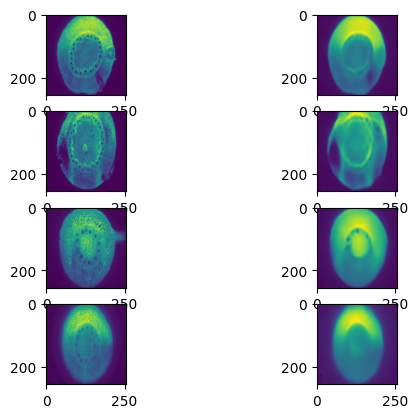

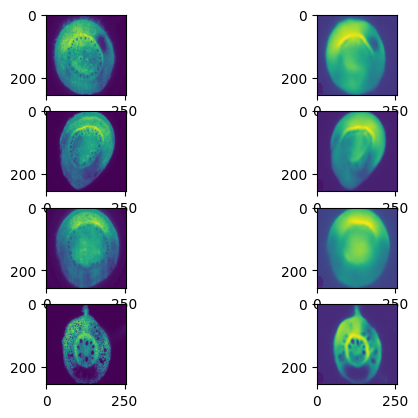

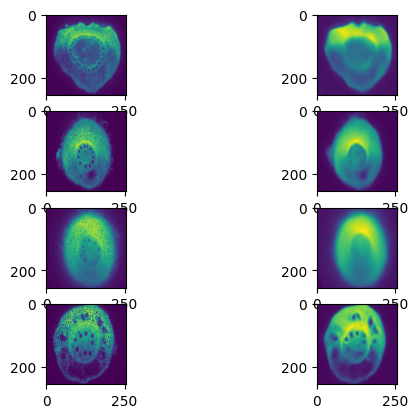

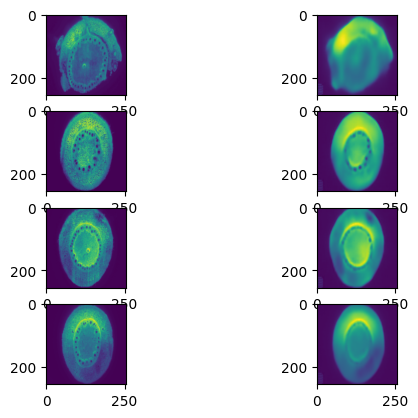

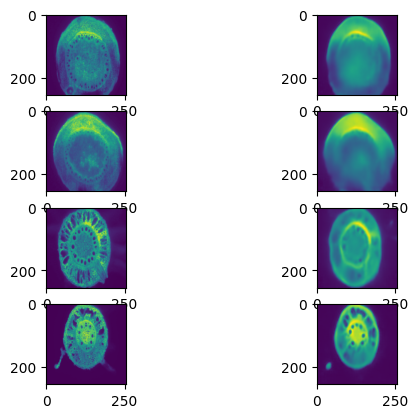

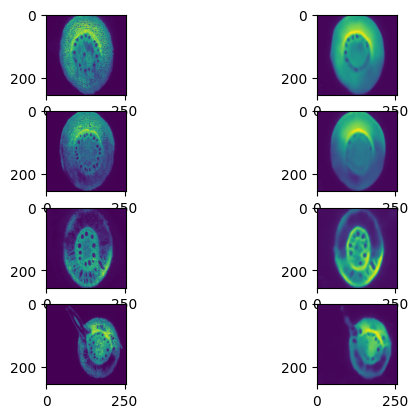

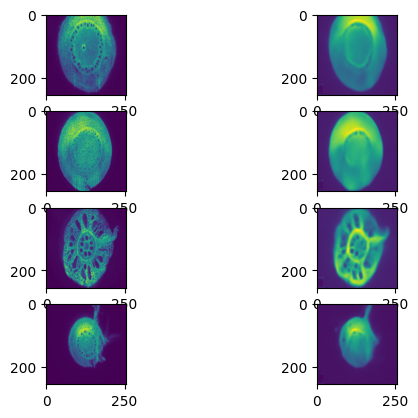

Done -- saved to: /code/checkpoints/vae


In [4]:
from models.jax_vae_t import VAE
from root.load_tfrecords import Dataloader
import jaxwt as jwt
import flax.linen as nn 

class TrainState(train_state.TrainState):
    pass 
    # batch_stats: Any


def gaussian_filter(images):
    kernel = jnp.array([[0.0751, 0.1238, 0.0751],
                        [0.1238, 0.2042, 0.1238], 
                        [0.0751, 0.1238, 0.0751]])[None, None, :, :]
    return jax.lax.conv_general_dilated(
        images[:, None, :, :], kernel, [1, 1], 'SAME'
    )[:, 0, :, :]


@jax.jit
def wavelet_transform(data):
    dec_filt = jnp.array([
       [[[0.49999997, 0.49999997], [0.49999997, 0.49999997]]],
       [[[0.49999997, 0.49999997], [-0.49999997, -0.49999997]]],
       [[[0.49999997, -0.49999997], [0.49999997, -0.49999997]]],
       [[[0.49999997, -0.49999997], [-0.49999997, 0.49999997]]]
    ])
    
    wavelet_kernel = jnp.transpose(dec_filt, (2, 3, 1, 0))
    conv = nn.Conv(features=4, kernel_size=(2, 2), strides=(2, 2), padding='VALID', use_bias=False)
    return conv.apply({'params': {'kernel': wavelet_kernel}}, data)
    

@jax.jit
def train_step(
    state_, 
    input_imgs_,
    input_waves_, 
    rng_key,
):
    def loss_fn(params_):
        (x_recon, x_wave, mu, log_var) = state_.apply_fn(
            {'params': params_}, #'batch_stats': state_.batch_stats},
            input_waves_,
            # mutable=['batch_stats'],
            training=True,
            key=rng_key
        )

        # xx = gaussian_filter(input_imgs_[..., 0])
        # xx_hat = gaussian_filter(x_recon)
        # recon_loss = jnp.mean(jnp.abs(xx - xx_hat)) 
        recon_loss = jnp.mean(jnp.square(input_imgs_ - x_recon[..., jnp.newaxis]))
        wave_loss = jnp.mean(jnp.square(input_waves_ - x_wave))
        
        tot_err = wave_loss + recon_loss
        
        return tot_err, (tot_err)

    grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
    aux, grads = grad_fn(state_.params)
    tot_loss, (tot_loss_) = aux
    
    new_state = state_.apply_gradients(grads=grads)
    # new_state = new_state.replace(batch_stats=updates['batch_stats'])

    return new_state, tot_loss_


@jax.jit
def reconstruct_batch(state, input_waves, rng_key):
    """Get reconstructions for visualization"""
    (x_recon, x_waves, mu, log_var) = state.apply_fn(
        {'params': state.params},#, 'batch_stats': state.batch_stats},
        input_waves,
        training=False,
        key=rng_key
    )
    return x_recon, x_waves, mu, log_var




if __name__ == "__main__":

    # GPU Check and Setup
    print("🔧 Checking GPU availability...")
    print(f"JAX devices: {jax.devices()}")
    print(f"JAX default backend: {jax.default_backend()}")
    
    try:
        gpu_devices = jax.devices('gpu')
        if gpu_devices:
            print(f"✅ Found {len(gpu_devices)} GPU(s): {gpu_devices}")
            print("🎯 Setting JAX to use GPU...")
        else:
            print("⚠️ No GPU devices found - using CPU")
    except Exception as e:
        print(f"⚠️ GPU check failed: {e}")
        print("Using default JAX configuration")
    
    compute_dtype = jnp.float32
    
    # Initialize model
    print("Initializing VAE model...")
    vae = VAE(base_features=48, latent_dim=256)
    key = random.PRNGKey(42)
    x = random.uniform(key, (1, 128, 128, 4))
    key, init_key, sample_key = random.split(key, 3)
    variables = vae.init(init_key, x, sample_key, training=False)
    # print(vae.tabulate(init_key, x, sample_key, training=False))
    # fdsf
    print("Model initialized!")
    
    # Training setup
    key = random.key(0)
    key, *subkeys = random.split(key, 4)
    
    learning_rate = 0.01
    num_epochs = 200
    batch_size = 32
    
    print(f"📋 Training Configuration:")
    print(f"   Learning Rate: {learning_rate}")
    print(f"   Epochs: {num_epochs}")
    print(f"   Batch Size: {batch_size}")
    print()
 
    params= variables['params']# , variables['batch_stats']
    tx = optax.adamw(learning_rate)

    state = TrainState.create(
        apply_fn=vae.apply,
        params=params,
        tx=tx,
        # batch_stats=batch_stats
    )
    
    # Initialize dataloader
    print("📂 Setting up dataloader...")
    dataloader = Dataloader(tfrecord_pattern=os.path.join(dataset_path, "*.tfrecord"), batch_size=batch_size)
    jax_ds = dataloader.get_jax_iterator(shuffle=True)
    batches_per_epoch = (4731 // batch_size)
    print("Dataloader ready!")
    print()
    
    print("Starting training loop...")
    print("-" * 80)
    
    for epoch in tqdm(range(num_epochs), desc="Adaptive Training Progress"):

        epoch_start = time.time()
        
        for batch_idx in range(batches_per_epoch):
            batch_start = time.time()
            
            # Get batch
            subkeys[2], key1, key2 = random.split(subkeys[2], 3)
            batch_ = next(jax_ds)
            perm = random.permutation(key1, batch_size)
            
            permuted_imgs = batch_['features'][perm, ...]
            # transformed = jwt.wavedec2(permuted_imgs, "haar", level=1, mode="reflect", axes=(1,2))
            # # NOTE: this is because of the ordering in torch == BE CAREFUL
            # permuted_waves = jnp.concatenate([transformed[0], transformed[1][1], transformed[1][0], transformed[1][2]], axis=-1)
            # permuted_waves = jax.lax.stop_gradient(permuted_waves)
            permuted_waves = wavelet_transform(permuted_imgs)
            permuted_waves = jax.lax.stop_gradient(permuted_waves)
            # print(jnp.sum(wavvy - permuted_waves))

            # Train step
            state, total_loss = train_step(
                state, permuted_imgs, permuted_waves, key2
            )
            
            batch_time = time.time() - batch_start
            
            # print('LOSSES:', total_loss)
        
        epoch_time = time.time() - epoch_start
        
        # Show reconstructions every 5 epochs
        if epoch % 5 == 0 or epoch == num_epochs - 1:
            key = visualize_reconstructions(state, permuted_imgs, permuted_waves, key, num_samples=4)
        
        # print("-" * 60)
    ckpt = {'model': state.params}
    
    import orbax
    from flax.training import orbax_utils

    orbax_checkpointer = orbax.checkpoint.PyTreeCheckpointer()
    save_args = orbax_utils.save_args_from_target(ckpt)
    
    # Remove the directory if it exists
    checkpoint_path = '/code/checkpoints/vae'
    if os.path.exists(checkpoint_path):
        shutil.rmtree(checkpoint_path)
    
    # Now save the checkpoint
    orbax_checkpointer.save(checkpoint_path, ckpt, save_args=save_args)
    print('Done -- saved to:', checkpoint_path)
        